## Figure 6 info

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
%matplotlib inline

# from methods.BIGC import blind_inverse_gamma_correction
# from methods.CAB import correct_average_brightness as cab
# from methods.AGT import adaptive_gamma_transform

from methods.BIGC import BIGC
from methods.CAB import CAB
from methods.GCMV import GCMV
from methods.GCMP import GCMP
from methods.GCME import GCME
from methods.metrics import m_entropy, m_power, m_contrast, m_EMEG

In [2]:
# Calculate the entropy of an image
def entropy(img):
    if img.ndim > 2:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    p = np.zeros(256)
    
    for i in range(256):
        p[i] = np.sum(gray[:]==i).astype(float)/(gray.shape[0]*gray.shape[1])
    
    entropy = 0.0
    for i in range(256):
        if p[i]>0:
            entropy -= p[i]*np.log(p[i])
    return entropy

<function matplotlib.pyplot.show(close=None, block=None)>

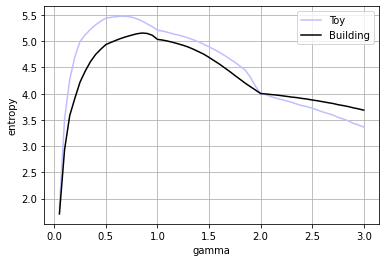

In [3]:
# Read the images and compute the entropy of each images
image_path = ["../images/camera/car/","../images/camera/buildings/"]
gamma = 0.05*np.linspace(1,60,60)
labels = ["Toy", "Building"]
images = [list(),list()]
entropies = [list(),list()]
for i in range(2): # Toy and Building 
    for j in range(1,61):
        img = cv2.imread(os.path.join(image_path[i],str(j)+"image.bmp"))
        images[i].append(img)
        entropies[i].append(entropy(img))
        
# plot the entropy VS gamma relationship for fun
plt.figure()
plt.plot(gamma, np.array(entropies[0]),label=labels[0], color=(0.75,0.75,1.0))
plt.plot(gamma, np.array(entropies[1]),label=labels[1], color=(0.00,0.00,0.0))
plt.xlabel("gamma")
plt.ylabel("entropy")
plt.legend()
plt.grid()
plt.show

In [ ]:
def measure(case,index, name=None):
    image = images[case][index]
    img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    m_ent, m_pw = m_entropy(img, False), m_power(img, False) # images from camera don't have peak-gap pattern
    m_cont, m_e = m_contrast(img), m_EMEG(img)
    info = f'Entropy:{m_ent:6.3f} Power:{m_pw:7.5f} Contrast:{m_cont:6.3f} EMEG:{m_e:6.3f}'
    print(info)
    
    # save the image here
    if name is not None:
        cv2.imwrite(f"case{case}_{name}.bmp", image)
    
# Set the initial gamma, get the corresponding index
gamma_init = 0.75
index_init = np.round(gamma_init/0.05).astype(np.int) - 1  

# init_index = int(init_gamma/0.05) - 1
label2 = [["a","b","c","d","e","f"],["g","h","i","j","k","l"]]
methods = ['BIGC','CAB','GCMV','GCMP','GCME']


for i in range(2): # 'car' and 'building'
    print("*"*20)
    # read the initial image
    img_init = images[i][index_init]
    img_init = cv2.cvtColor(img_init, cv2.COLOR_BGR2GRAY)
    
    print(f'Init case:{(index_init+1)*0.05}')            
    measure(i, index_init,'Init')
    
    # get the image with max entropy
    index_max_entr = np.argmax(np.array(entropies[i]))
    print(f'Maximum Entropy:{(index_max_entr+1)*0.05}')            
    measure(i, index_max_entr, 'MaxE')

    # Gamma Correction method
    for method in methods:
        gamma_delta, _ =  eval(method)(img_init)
        gamma = gamma_init * gamma_delta
        index = np.round(gamma/0.05).astype(np.int) - 1
        info =f'{method}:{(index+1)*0.05:2.0f}'
        print(info)            
        measure(i, index, method)

********************
Init case:0.75
Entropy: 5.460 Power:0.00479 Contrast:74.625 EMEG: 0.434
Maximum Entropy:0.65
